# Human TTN遺伝子の両端の配列に着目しmotif配列の検出を行う

### human_motif_comb.ipynbの内容
複数個の塩基を組み合わせた配列を作成し、それらの各イントロン領域における出現頻度を解析

### 準備
```
gbk = Seq_count() # クラスのインスタンス化
gbk.read_gbk('data/gbk/human_ttn.gb')　# gbkファイルの読み込み
```

### 特定のイントロン領域の組み合わせ配列の統計をデータフレームで返す
イントロン88のの配列の統計情報
組み合わせ配列の塩基数:4
```
gbk.intron_motif_stats(intron=88, n=4)
```

### 指定したインロンの配列を返す
```
gbk.intron_seq(77) # 77番目のイントロン配列を取得
```

## 準備

In [33]:
# オリジナルモジュールのインポート
from lib.introngap import PileUp
from lib.gbkparse import Seq_count

# モジュールのインポート
import itertools
import logomaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
# クラスのインスタンス化
gbk = Seq_count()

# gbkファイルの読み込み
gbk.read_gbk('../data/gbk/human_ttn.gb')

In [35]:
# 登録されているmRNAのIDを取得
for i in gbk.get_mrna_ids():
    gbk.set_mrna_id(i)
    print(i,gbk.intron_num())

NM_003319.4 190
NM_133437.4 191
NM_133432.3 191
NM_133378.4 311
XM_017004821.1 335
NM_001256850.1 312
NM_001267550.2 362
XM_017004820.1 335
XM_024453099.1 190
XM_017004823.1 191
XM_047445668.1 276
XM_024453098.1 271
XM_024453097.1 272
XM_017004822.1 273
XM_047445665.1 281
XM_047445663.1 299
XM_024453095.1 309
XM_047445660.1 316
XM_047445661.1 312
XM_017004819.1 358
NM_133379.5 45
XM_024453100.2 183


In [36]:
# トランスクリプトバリアントの設定
gbk.set_mrna_id('NM_001267550.2')

## すべてのイントロンの両端n塩基を抽出し主成分分析を行う

In [37]:
# 各イントロンの両端n塩基を抽出し
n = 30

# 各イントロンの5-prime側のn塩基を抽出 
left_egdes = []
for i in range(gbk.intron_num()):
    left_egdes.append(str(gbk.intron_seq(i+1)[:n]))
    
# 各イントロンの3-prime側のn塩基を抽出
right_egdes = []
for i in range(gbk.intron_num()):
    right_egdes.append(str(gbk.intron_seq(i+1)[-n:]))

### 抽出した配列のワンホットエンコーディングと主成分分析
各イントロンの5-prime側のn塩基の主成分分析

In [38]:
# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
encoded_sequences = np.array([one_hot_encode(seq) for seq in left_egdes])

# 主成分分析（PCA）
pca_l = PCA(n_components=2)  # 2つの主成分を取得
principal_components = pca_l.fit_transform(encoded_sequences)

# 主成分をデータフレームに変換
df_pca_l = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# 結果をプロット
fig = px.scatter(df_pca_l, x='PC1', y='PC2', hover_name=[f"intron_{i+1}" for i in range(gbk.intron_num())] )
fig.show()


In [39]:
fig = px.bar(x=df_pca_l.index, y=df_pca_l['PC1'])
fig.show()

In [40]:
# 因子負荷量の計算
loadings_l = pca_l.components_.T * np.sqrt(pca_l.explained_variance_)

# 結果の表示
loadings_ldf = pd.DataFrame(loadings_l, columns=['PC1', 'PC2'])
ldf_l = pd.DataFrame(loadings_ldf)
ldf_l.sort_values('PC1')

fig = px.bar(x=ldf_l.index, y=ldf_l['PC1'])
fig.show()

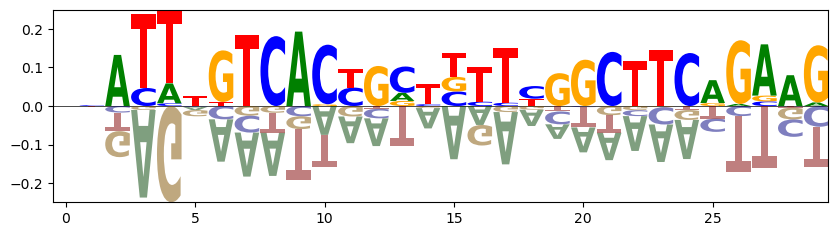

In [41]:
# ワンホットエンコーディングをデコードする
# 負荷量の最も高い塩基を取得し、配列を作成する
b_df_l = pd.DataFrame(ldf_l['PC1'].to_numpy().reshape(n,4))
b_df_l.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(b_df_l, shade_below=.5, fade_below=.5)

各イントロンの3-prime側のn塩基の主成分分析

In [42]:
# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
encoded_sequences = np.array([one_hot_encode(seq) for seq in right_egdes])

# 主成分分析（PCA）
pca_r = PCA(n_components=2)  # 2つの主成分を取得
principal_components = pca_r.fit_transform(encoded_sequences)

# 主成分をデータフレームに変換
df_pca_r = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# 結果をプロット
fig = px.scatter(df_pca_r, x='PC1', y='PC2', hover_name=[f"intron_{i+1}" for i in range(gbk.intron_num())] )
fig.show()


In [43]:
fig = px.bar(x=df_pca_r.index, y=df_pca_r['PC1'])
fig.show()

In [44]:
# 因子負荷量の計算
loadings_r = pca_r.components_.T * np.sqrt(pca_r.explained_variance_)

# 結果の表示
loadings_rdf = pd.DataFrame(loadings_r, columns=['PC1', 'PC2'])
ldf_r = pd.DataFrame(loadings_rdf)
ldf_r.sort_values('PC1')

fig = px.bar(x=ldf_r.index, y=ldf_r['PC1'])
fig.show()

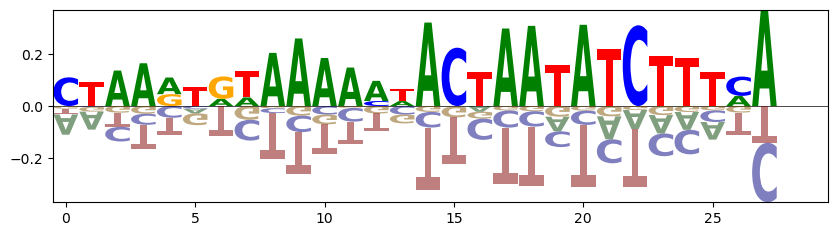

In [45]:
# ワンホットエンコーディングをデコードする
# 負荷量の最も高い塩基を取得し、配列を作成する
b_df_r = pd.DataFrame(ldf_r['PC1'].to_numpy().reshape(n,4))
b_df_r.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(b_df_r, shade_below=.5, fade_below=.5)


In [46]:
# 上記の配列の一部が末尾n塩基に含まれているイントロンを抽出
mtf = "ACTAATATCTT"
for i in range(gbk.intron_num()):
    if mtf in gbk.intron_seq(i+1)[-n:]:
        print(f"intron_{i+1}")
        seq = str(gbk.intron_seq(i+1)[-n:])
        seq = seq.replace(mtf,f"<{mtf}>")
        print(seq)
        print("")

intron_155
TTCTAAACCAAAAT<ACTAATATCTT>TGAAG

intron_158
GTAACAATTAATAT<ACTAATATCTT>TAAAG

intron_159
CTAATTATTTAAAT<ACTAATATCTT>TAAAG

intron_161
TTAAATGTAAACCT<ACTAATATCTT>TAAAG

intron_162
CAATTAAAAAAAAT<ACTAATATCTT>TAAAG

intron_164
CCTCTAACCATAAT<ACTAATATCTT>CAAAG

intron_168
CTGAGTGTAAAAAT<ACTAATATCTT>TCAAG

intron_169
CTAAATGTAATTTC<ACTAATATCTT>TCAAG

intron_171
CTAAATGTAATTTC<ACTAATATCTT>TCAAG

intron_172
CTAATAATGAAAAT<ACTAATATCTT>TAAAG

intron_174
TCTAACTAAAAGAT<ACTAATATCTT>CAAAG

intron_175
TAAATTATAAAAAT<ACTAATATCTT>TCAAG

intron_176
CTAAGTATAAAACT<ACTAATATCTT>TCAAG

intron_177
TTAAGTCTAAAACT<ACTAATATCTT>TCAAG

intron_178
CTAAGTGAAAAACT<ACTAATATCTT>TCAAG

intron_179
CCACATGTAACTTT<ACTAATATCTT>TTAAG

intron_180
CTAAATGTAATTTC<ACTAATATCTT>TCAAG

intron_181
CTAATAATGAAAAT<ACTAATATCTT>TAAAG

intron_183
TCTAACTAAAAGAT<ACTAATATCTT>CAAAG

intron_184
TAAATTATAAAAAT<ACTAATATCTT>TCAAG

intron_185
CTAAGTATAAAACT<ACTAATATCTT>TCAAG

intron_186
TTAAGTCTAAAACT<ACTAATATCTT>TCAAG

intron_187